### MWE
This notebook contains a minimal working example for the package.  
You have to install the `graphviz` library if you want to plot the model in this notebook.

In [1]:
from param.core import Model
from param.dists.norm import NormalDistribution

Using TensorFlow backend.


To be able to create a model, we need to provide several parameters:
* `n_samples`: Total number of samples to train this network on.
* `desired_grid_size`: Desired size of the grid; may get adjusted and is available as grid_size.
* `n_epochs`: Number of epochs to use when using this parameters on training a model.
* `batch_size`: Batch size.
* `n_dense_layers`: Number of dense layers per first and second level.
* `dense_scaling`: Scaling for the number of neurons in the first dense layer (dense_scaling * depth)
* `depth`: Model depth.
* `n_kernels`: Number of kernels to use.
* `kernel_size`: Size of the kernels.
* `name`: Name of the network, can be set on initialization or afterwards.

Note that the actual `grid_size` gets adjusted so that the network has correct dimensions. Similarly, `out_dense_2` also gets adjusted:

```out_dense_2 = (desired_grid_size + kernel_size - 1) // n_dense_layers
grid_size = out_dense_2 * n_dense_layers - kernel_size + 1
```

Varying any of `desired_grid_size`, `kernel_size` or `n_dense_layers` will therefore also effect `out_dense_2` and `grid_size`.

The following example should illustrate the purpose of the parameters.

In [2]:
model = Model(n_samples=100000, desired_grid_size=150, n_epochs=5, batch_size=32, n_dense_layers=10,
              dense_scaling=1.0, depth=10, n_kernels=15, kernel_size=40, name='MWE')

# Store the parameters which were used to create this model.
# model.params_to_csv(os.path.join(path, 'model-params.csv'))

grid_size = 141 , out_dense_2 = 18
Instructions for updating:
Colocations handled automatically by placer.


As the Model class inherits from *keras.Model*, we can apply any method applicable to *keras.Model* once we created our model:

In [3]:
model.compile(optimizer='adam', loss='mean_squared_error')

To understand what the parameters mentioned before actually do, we can have a look at the plotted model:

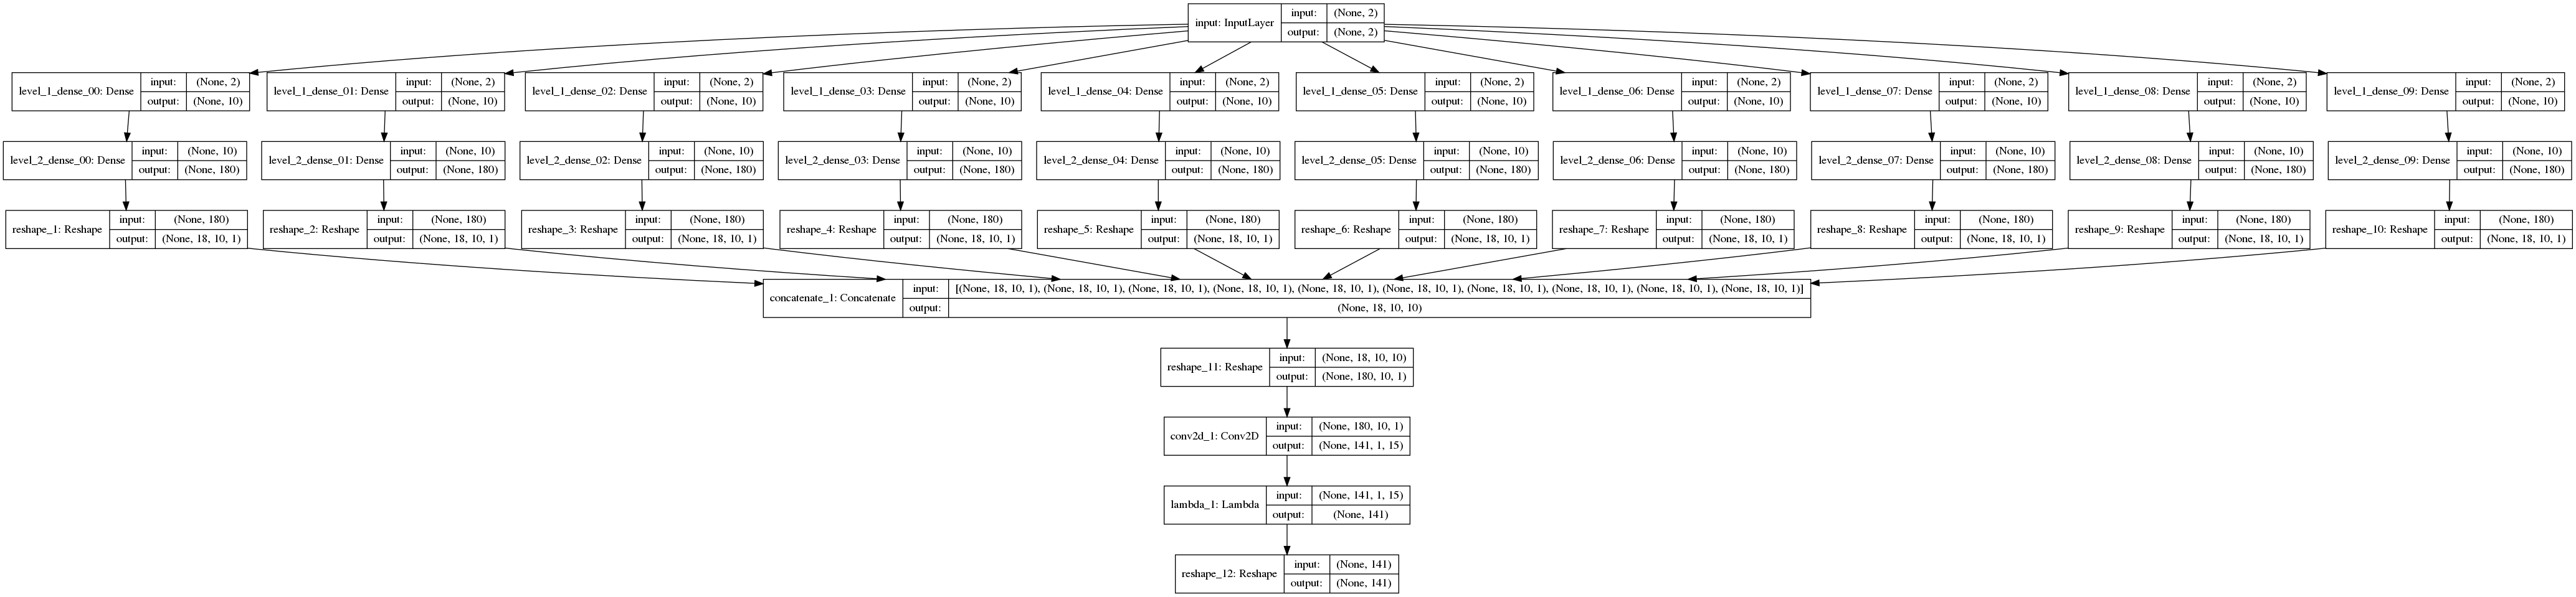

In [4]:
model.plot(show_shapes=True, to_file='model.png')

# Just for jupyter notebooks:
from IPython.display import Image, display
display(Image(retina=True, filename='model.png'))

Note how the actual output from the dense layers is multiplied with the `depth`, i.e. `10 * 18` for the second level.  

Now that we have a model, we can create a distribution to sample from.

In [5]:
# We define the parameters here because we will use them again later on.

In [6]:
X_MIN, X_MAX = -10, 10
MU_MIN, MU_MAX = -3, 3
SIGMA_MIN, SIGMA_MAX = 0.5, 3

In [7]:
dist = NormalDistribution(name="MWE Dist", x_min=X_MIN, x_max=X_MAX, mu_min=MU_MIN, mu_max=MU_MAX,
                          sigma_min=SIGMA_MIN, sigma_max=SIGMA_MAX)

We want to sample `n_samples` vectors of parameters, which we then use to generate data from the distribution. This results in data grids of size `model.grid_size` (note that this is not the `desired_grid_size`, but was determined/adjusted by the other parameters in the model).

In [8]:
sampled_params, sampled_grid = dist.gen_data(model.n_samples, model.grid_size)

Now that we have everything, we can fit our model.

In [9]:
model.fit(sampled_params, sampled_grid, shuffle=True, batch_size=model.batch_size,
          epochs=model.n_epochs, callbacks=[model.history])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
100000/100000 [==============================] - 39s 391us/step - loss: 33.6746
Epoch 2/5
100000/100000 [==============================] - 39s 386us/step - loss: 0.1256
Epoch 3/5
100000/100000 [==============================] - 39s 387us/step - loss: 0.0722
Epoch 4/5
100000/100000 [==============================] - 39s 389us/step - loss: 0.0854
Epoch 5/5
100000/100000 [==============================] - 44s 442us/step - loss: 0.0526


If we want we can store our model as a .h5 file and the losses as a .csv.

In [10]:
model.save('model.h5')
#model.loss_to_csv('loss.csv')

Now that we have our trained model, we can find out how well it actually does on novel data.  
Furthermore, it is also possible to load a stored model which comes in handy when a model was trained on a cluster.

In [11]:
#from keras.models import load_model
#m = load_model('model.h5')

We will compare our model trained on a normal distribution against the maximum likelihood method.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import stats as ss
from scipy.interpolate import griddata

In [13]:
def log_likelihood(model, theta, x_grid, x):
    if np.abs(theta[0]) > 3 or theta[1] < 0.5 or theta[1] > 3:  # Check whether we are outside of the chosen parameters.
        return -1e9
    
    theta = np.atleast_2d(theta)
    likelihood_on_grid = model.predict(theta).T
    
    points = np.atleast_2d(x_grid).T

    ll = griddata(x_grid, likelihood_on_grid, x, fill_value=-1e9)
    
    return ll

In [14]:
def get_summed_ll(model, theta, x_grid, x):
    return np.sum(log_likelihood(model, theta, x_grid, x))

In [15]:
def estimate_params(model, x_grid, x):
    return optimize.minimize(lambda theta: -get_summed_ll(model, theta, x_grid, x), 
                             x0=[0, 1], 
                             method='Nelder-Mead').x[0:2]

We simulate the results for ML and our model for a single set of parameters and interpolate over the chosen samples in `log_likelihood()`

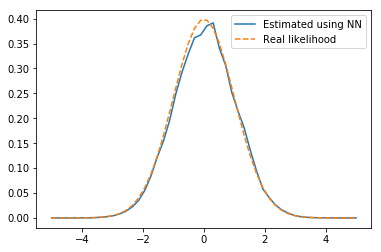

In [17]:
theta = np.array([0, 1]) # Mean 0, SD 1.
test_grid = np.linspace(-10, 10, model.grid_size)
samples = np.linspace(-5, 5)
ll = log_likelihood(model, theta, test_grid, samples)
    
plt.plot(samples, np.exp(ll), label='Estimated using NN')
plt.plot(samples, ss.norm(theta[0], theta[1]).pdf(samples), ls='--', label='Real likelihood')
plt.legend()

As we have trained a (computationally) cheap model, the results aren't as good as they could be with a larger training time and tweaked parameters.  
For further analysis, we can look how ML compares against our NN approach across different grid sizes.

In [18]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from itertools import product

In [22]:
mu_list = []
sigma_list = []

n_ns = 10  # Number of invervals.
n_runs = 10  # Number of trials per interval.
n_params = 5  # Number of parameter vectors sampled and to sample from.

# Sample some parameters.
mus = ss.uniform(MU_MIN, MU_MAX - MU_MIN).rvs(n_params)
sigmas = ss.uniform(SIGMA_MIN, SIGMA_MAX - SIGMA_MIN).rvs(n_params)

# Create permutations.
pars = product(np.linspace(50, 100, n_ns, dtype=int), np.arange(n_runs), zip(mus, sigmas))
test_grid = np.linspace(X_MIN, X_MAX, model.grid_size)  # Grid size of the model to use for the interpolation.

with tqdm(total=n_ns*n_params*n_runs) as t:
    for n, trial, params in pars:
        test_data = ss.norm(params[0], params[1]).rvs(n)

        params_est = estimate_params(model, test_grid, test_data)
        mu_estimate = params_est[0]
        sigma_estimate = params_est[1]
        
        ml_mu_estimate = np.mean(test_data)
        ml_sigma_estimate = np.std(test_data)

        mu_list.append({'n':n,
                        'trial':trial,
                        'mu':params[0],
                        'mu_nn':mu_estimate,
                        'mu_ml':ml_mu_estimate
                       })
        
        sigma_list.append({'n':n,
                           'trial':trial,
                           'sigma':params[1],
                           'sigma_nn':sigma_estimate,
                           'sigma_ml':ml_sigma_estimate
                          })
        t.update()
    
mu_df = pd.DataFrame(mu_list)
sigma_df = pd.DataFrame(sigma_list)

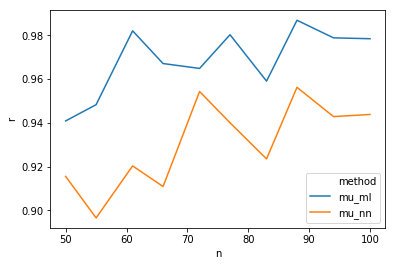

In [23]:
mu_df = mu_df.melt(id_vars=['mu', 'n', 'trial'], var_name='method', value_name='estimate')
mu_df = mu_df.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['mu'])[0]).to_frame('r')
sns.lineplot('n', 'r', 'method', data=mu_df.reset_index())

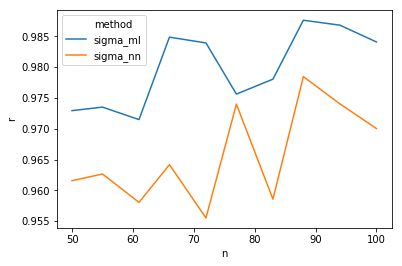

In [25]:
sigma_df = sigma_df.melt(id_vars=['sigma', 'n', 'trial'], var_name='method', value_name='estimate')
sigma_df = sigma_df.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['sigma'])[0]).to_frame('r')
sns.lineplot('n', 'r', 'method', data=sigma_df.reset_index())